In [159]:
from subprocess import Popen, PIPE
import shlex

import copy, os, time
import numpy as np
import pandas as pd
import scanpy as sc
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
from mpl_chord_diagram import chord_diagram
from mycolorpy import colorlist as mcp
#from marker_count import MarkerCount_Ref, MarkerCount

def run_command(cmd, verbose = True):
    cnt = 0
    with Popen(shlex.split(cmd), stdout=PIPE, bufsize=1, \
               universal_newlines=True ) as p:
        for line in p.stdout:
            if (line[:14] == 'Tool returned:'):                    
                cnt += 1
            elif cnt > 0:
                pass
            else: 
                if verbose:
                    print(line, end='')
                    
        exit_code = p.poll()
    return exit_code

def get_cellphonedb_res(out_dir):
     ## Load p_values
    df_pval = pd.read_csv('%s/pvalues.txt' % out_dir, sep = '\t', index_col = 0)    
    df_pval_items, df_pval_pairs = split_cellphonedb_out(df_pval)
    
    ## Load means
    df_mean = pd.read_csv('%s/means.txt' % out_dir, sep = '\t', index_col = 0)    
    df_mean_items, df_mean_pairs = split_cellphonedb_out(df_mean)
    
    idxp = list(df_pval_items.index.values)
    idxm = list(df_mean_items.index.values)
    idxc = set(idxp).intersection(idxm)
    cnt = 0
    for p, m in zip(idxp, idxm):
        if p != m:
            cnt += 1
    if cnt > 0:
        print( len(idxc), len(df_pval_items.index.values), len(df_mean_items.index.values), cnt )
    
    
    return df_mean_items, df_mean_pairs, df_pval_items, df_pval_pairs 

def split_cellphonedb_out(df):

    cols = df.columns.values
    items = cols[:10]
    pairs = cols[10:]

    df_items = df[items]
    df_pairs = df[pairs]
    
    return df_items, df_pairs
    
def cellphonedb_run( df_cell_by_gene, cell_types, out_dir = None, \
                     gene_id_type = 'gene_name' ):
    
    start = time.time()
    print('Running CellPhoneDB .. ')
    
    ## Normalize
    X = df_cell_by_gene.copy(deep = True)
    X_tmp = (X.div(X.sum(axis = 1), axis = 0)*1e6).astype(int)
    
    if not os.path.isdir(out_dir):
        mkdir(out_dir)
        
    if out_dir[-1] == '/':
        out_dir = out_dir[:-1]
    
    file_meta = '%s/meta_tmp.tsv' % out_dir
    file_cpm = '%s/exp_mat_tmp.tsv' % out_dir
    
    X_tmp.transpose().to_csv(file_cpm, sep = '\t')
    df_celltype = pd.DataFrame({'cell_type': cell_types}, index = X.index.values)    
    df_celltype.to_csv(file_meta, sep = '\t')
    
    cmd = 'cellphonedb method statistical_analysis '
    cmd = cmd + '%s %s ' % (file_meta, file_cpm)
    cmd = cmd + '--counts-data=%s ' % gene_id_type
    # cmd = cmd + '--pvalue=%f ' % 0.05
    # cmd = cmd + '--iterations=%i ' % 100
    # cmd = cmd + '--threshold=%f ' % 0.01
    cmd = cmd + '--output-path %s ' % out_dir

    run_command(cmd) 
    
    ## Generate CellPhoneDB summary
    out_file = 'results.pdf'

    cmd = 'cellphonedb plot dot_plot '
    cmd = cmd + '--means-path %s ' % ('%s/means.txt' % out_dir)
    cmd = cmd + '--pvalues-path %s ' % ('%s/pvalues.txt' % out_dir)
    cmd = cmd + '--output-path %s ' % out_dir
    cmd = cmd + '--output-name %s ' % out_file

    run_command(cmd)    

    ## Load p_values
    df_pval = pd.read_csv('%s/pvalues.txt' % out_dir, sep = '\t', index_col = 0)    
    df_pval_items, df_pval_pairs = split_cellphonedb_out(df_pval)
    
    ## Load means
    df_mean = pd.read_csv('%s/means.txt' % out_dir, sep = '\t', index_col = 0)    
    df_mean_items, df_mean_pairs = split_cellphonedb_out(df_mean)
    
    idxp = list(df_pval_items.index.values)
    idxm = list(df_mean_items.index.values)
    idxc = set(idxp).intersection(idxm)
    cnt = 0
    for p, m in zip(idxp, idxm):
        if p != m:
            cnt += 1
    if cnt > 0:
        print( len(idxc), len(df_pval_items.index.values), len(df_mean_items.index.values), cnt )
    
    elapsed = time.time() - start
    print('Running CellPhoneDB .. done. %i' % elapsed )
    
    return df_mean_items, df_mean_pairs, df_pval_items, df_pval_pairs   


def to_vector(df, rows, cname):
    
    cols = df.columns.values
    # rows = df.index.values
    
    idxs = []
    gps = []
    cps = []
    vals = []
    
    for c in list(cols):
        vt = list(df[c])
        ct = [c]*len(vt)
        gt = list(rows)
        it = []
        for r in gt:
            idx = '%s--%s' % (r,c)
            it.append(idx)
            
        idxs = idxs + it
        gps = gps + gt
        cps = cps + ct
        vals = vals + vt
        
    dfo = pd.DataFrame({'gene_pair': gps, 'cell_pair': cps, cname: vals}, index = idxs)
    
    return dfo

def cellphonedb_get_vector( df_info, df_mean_pairs, df_pval_pairs, pval_max = 0.05 ):
    
    dfp = to_vector(df_pval_pairs, df_info['interacting_pair'], 'pval')
    dfm = to_vector(df_mean_pairs, df_info['interacting_pair'], 'mean')
   
    '''
    ren_dict = {}
    for i in list(df_info.index.values):
        red_dict[i] = df_info.loc[i,'interacting_pair']
    
    dfp.rename(index = ren_dict, inplace = True)
    dfm.rename(index = ren_dict, inplace = True)
    '''
    
    b = (dfp['pval'] <= pval_max) & (~dfp['pval'].isnull()) & (~dfm['mean'].isnull()) & (dfm['mean'] > 0)
    dfp = dfp.loc[b,:].copy(deep=True)
    dfm = dfm.loc[b,:].copy(deep=True)   
    
    return dfp, dfm    


def cellphonedb_plot_result( dfp, dfm, mkr_sz = 8, tick_sz = 6, legend_font_sz = 11 ):
    
    y = len(set(dfp['gene_pair']))
    x = len(set(dfp['cell_pair']))
    
    print('%i gene pairs, %i cell pairs found' % (y, x))
    
    pv = -np.log10(dfp['pval']+1e-4).round()
    np.min(pv), np.max(pv)
    
    mn = np.log2((dfm['mean'])).round()
    np.min(mn), np.max(mn)    
    
    # figure(figsize=(8, 6*(y/x)), dpi=80)
    sc.settings.set_figure_params(figsize=(8, 8*(y/x)), dpi=80, facecolor='white')
    fig, ax = plt.subplots()

    mul = mkr_sz
    scatter = ax.scatter(dfm['cell_pair'], dfp['gene_pair'], s = pv*mul, c = mn, linewidth = 0, cmap = 'Reds')

    legend1 = ax.legend(*scatter.legend_elements(),
                        loc="lower left", bbox_to_anchor=(1.02, 0.5), title=" log2(mean) ", \
                        fontsize = legend_font_sz)
    legend1.get_title().set_fontsize(legend_font_sz)
    ax.add_artist(legend1)

    # produce a legend with a cross section of sizes from the scatter
    handles, labels = scatter.legend_elements(prop="sizes", alpha=0.6)
    labels = [1, 2, 3, 4]
    legend2 = ax.legend(handles, labels, loc="upper left", \
                        bbox_to_anchor=(1.02, 0.5), title="-log10(p_val)", \
                        fontsize = legend_font_sz)
    legend2.get_title().set_fontsize(legend_font_sz)

    plt.yticks(fontsize = tick_sz)
    plt.xticks(rotation = 90, ha='center', fontsize = tick_sz)
    # plt.grid(b=None)
    plt.margins(x=0.01, y=0.01/(y/x))
    plt.show()   
    

In [10]:
out_dir = '/home/mlbi/Desktop/HDD1/Work_SNU_JoongHo/BRCA_GSE180878/CPDB_res_PM-A'
df_mean_info, df_mean_pairs, df_pval_info, df_pval_pairs = get_cellphonedb_res(out_dir)

In [15]:
dfp_tmp, dfm_tmp = cellphonedb_get_vector( df_pval_info, df_mean_pairs, df_pval_pairs, pval_max = 0.05 )

In [167]:
def CellInteraction(x):
    return x.split('--')[-1]

def InteractionPlot(df):
    cells_df = df['cell_pair'].str.split(pat='|',expand=True)
    cells_df.columns=['Cell1','Cell2']
    cells_df['interaction'] = cells_df.index.map(CellInteraction)
    all_cells = list(set(cells_df['Cell1']).union(set(cells_df['Cell2'])))

    interaction_cnt = cells_df['interaction'].value_counts().to_frame()
    interaction_cnt['pair'] = list(interaction_cnt.index)
    print(interaction_cnt)

    n_cells = len(all_cells)
    adj_mat = np.zeros((n_cells,n_cells))
    cell_idx = dict(zip(all_cells,range(n_cells)))
    for vals in interaction_cnt.values:
        i_counts = vals[0]
        p = vals[1].split('|')
        row = cell_idx[p[0]]
        col = cell_idx[p[1]]
        adj_mat[row,col]=i_counts
        
    cordPalette = mcp.gen_color(cmap="Spectral",n=n_cells)
    cell_interactions = sum(sum(adj_mat == 0))
    interPalette = mcp.gen_color(cmap="jet",n=7)

    rotate_names = [True]*n_cells
    names = list(cell_idx.keys())

    sc.settings.set_figure_params(dpi=100, figsize=(6,6), fontsize=18)

    chord_diagram(adj_mat,names=names, alpha=0.7, sorts='size',
                  rotate_names=True, colors=interPalette, pad=10)
    plt.show()
    

                                 interaction                             pair
Macrophage|Macrophage                     18            Macrophage|Macrophage
Macrophage|Fibroblast                     16            Macrophage|Fibroblast
Fibroblast|T cell CD8+                    14           Fibroblast|T cell CD8+
Macrophage|T cell CD8+                    14           Macrophage|T cell CD8+
T cell CD8+|Macrophage                    12           T cell CD8+|Macrophage
Dendritic cell|Macrophage                 12        Dendritic cell|Macrophage
T cell CD4+|T cell CD4+                   10          T cell CD4+|T cell CD4+
T cell CD8+|T cell CD8+                   10          T cell CD8+|T cell CD8+
Dendritic cell|T cell CD4+                10       Dendritic cell|T cell CD4+
Dendritic cell|Dendritic cell              9    Dendritic cell|Dendritic cell
T cell CD8+|Dendritic cell                 9       T cell CD8+|Dendritic cell
T cell CD4+|Dendritic cell                 9       T cell CD4+|D

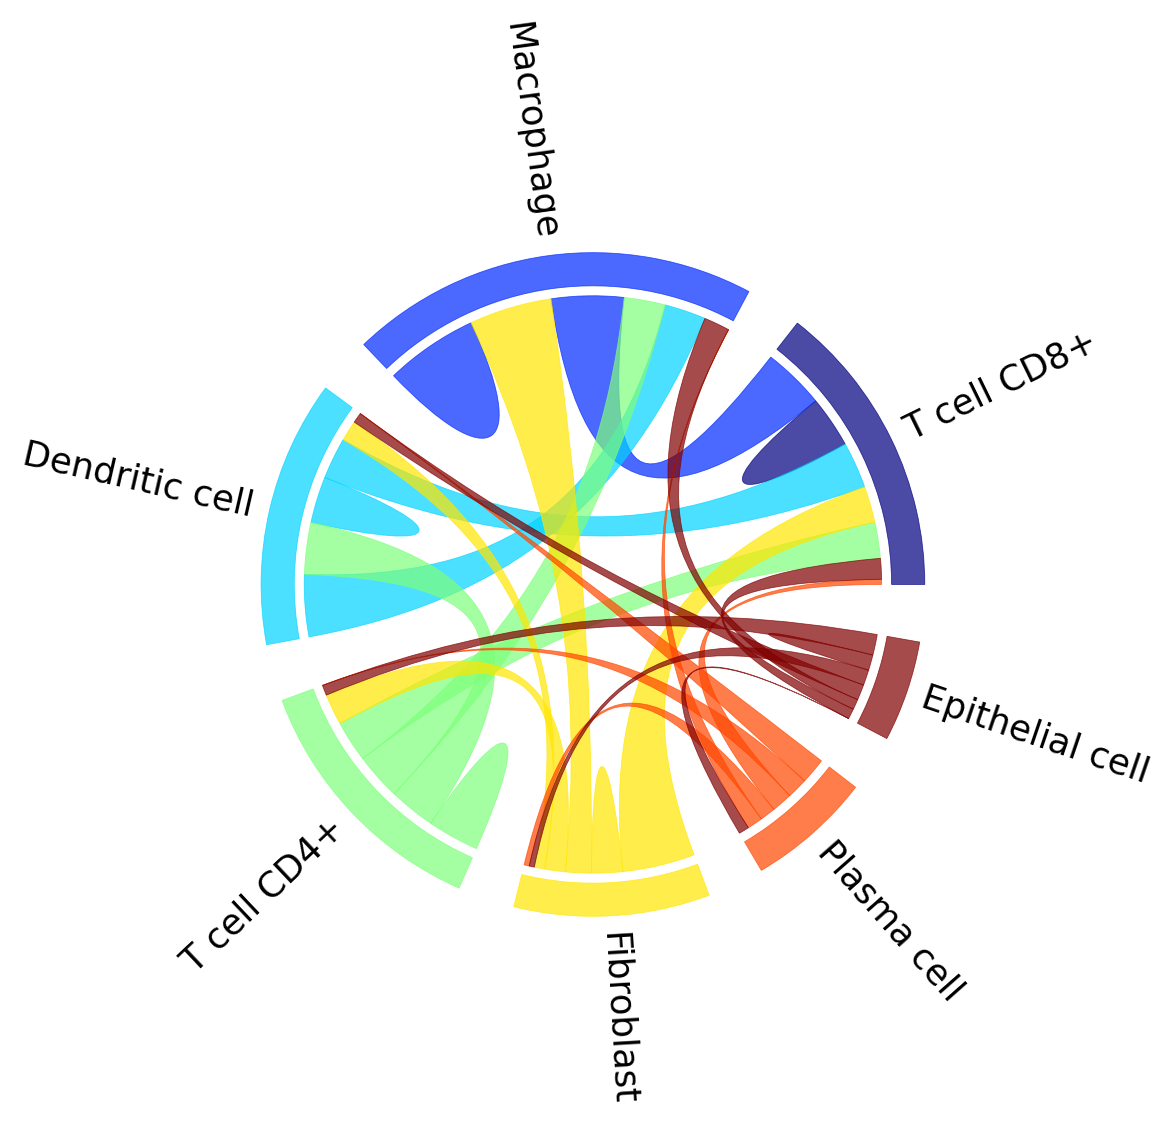

In [168]:
InteractionPlot(dfp_tmp)

